# Contenido

1. **Carga de librerías y datos**  
   - 1.a. Librerías  
   - 1.b. Funciones  
   - 1.c. Carga de datos  

2. **Modelado**  
   - 2.a. Creación variables exógenas
   - 2.b. Entrenamiento del modelo
   - 2.c. Evaluación


# 1. Carga de librerías y datos

## 1.a. Librerías

**Importante**: se deben instalar las mismas versiones de librerías que las utilizadas en el *notebook*

In [1]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)

# Procesado de datos
# ==============================================================================
import os
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset
from astral import LocationInfo
from astral.sun import sun

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Keras
# ==============================================================================
os.environ["KERAS_BACKEND"] = "tensorflow" # 'tensorflow', 'jax´ or 'torch'
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        import tensorflow
    elif keras.backend.backend() == "torch":
        import torch
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

# Modelado 
# ==============================================================================
import skforecast
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from sklearn.preprocessing import MinMaxScaler

from IPython.display import Image
import plotly.io as pio

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version Keras: {keras.__version__}")
print(f"{color}Using backend: {keras.backend.backend()}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")
if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        print(f"{color}Version tensorflow: {tensorflow.__version__}")
    elif keras.backend.backend() == "torch":
        print(f"{color}Version torch: {torch.__version__}")
    else:
        print(f"{color}Version torch: {jax.__version__}")

Version skforecast: 0.13.0
Version Keras: 3.7.0
Using backend: tensorflow
Version pandas: 2.0.3
Version numpy: 1.26.4
Version tensorflow: 2.16.2


## 1.b. Funciones

In [2]:
def train_val_test(datos, fin_train, fin_val):
    # Separación de datos en entrenamiento, validación y test
    # ==============================================================================
    datos_train = datos.loc[: fin_train]
    datos_val   = datos.loc[fin_train:fin_val]
    datos_test  = datos.loc[fin_val:]
    print(
        f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  "
        f"(n={len(datos_train)})"
    )
    print(
        f"Fechas validación : {datos_val.index.min()} --- {datos_val.index.max()}  "
        f"(n={len(datos_val)})"
    )
    print(
        f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  "
        f"(n={len(datos_test)})"
    )
    return datos_train, datos_val, datos_test

def imputar_nulos_por_hora(datos):
    datos.index = pd.to_datetime(datos.index)
    horas = datos.index.hour
    
    # Promedio por hora y sustitución el valores Nan
    media_por_hora = datos.groupby(horas).transform('mean')
    datos = datos.fillna(media_por_hora)
    
    return datos

## 1.c. Carga de datos


Datos BICING:

In [ ]:
df = pd.read_parquet('../../1-DATOS/2-DATOS PROCESADOS/BICING/INFORMACION COMPLETA/BICICLETAS_HORARIO_2022_2023_FILTRADO.parquet')
datos = df[494]
datos = imputar_nulos_por_hora(datos)

In [4]:
fin_train = '2023-04-30 23:59:00'
fin_val = '2023-09-30 23:59:00'

datos_train, datos_val, datos_test = train_val_test(datos, fin_train, fin_val)

Fechas train      : 2022-01-01 00:00:00 --- 2023-04-30 23:00:00  (n=11640)
Fechas validación : 2023-05-01 00:00:00 --- 2023-09-30 23:00:00  (n=3672)
Fechas test       : 2023-10-01 00:00:00 --- 2023-12-31 23:00:00  (n=2208)


# 2. Modelado

## 2.a. Creación variables exógenas

Se muestra un ejemplo sin utilizar variables exógenas.

## 2.b. Entrenamiento del modelo

In [5]:
def prepare_time_series(data, column_name='CANTIDAD', freq='H'):
    data = data.to_frame(name=column_name)
    data.index = pd.to_datetime(data.index)
    data = data.asfreq(freq)
    data.index.name = 'FECHA'
    return data

datos = prepare_time_series(datos)
datos_train = prepare_time_series(datos_train)
datos_val = prepare_time_series(datos_val)
datos_test = prepare_time_series(datos_test)

In [6]:
series = ['CANTIDAD']
levels = ["CANTIDAD"] 
lags = 168 # Valores pasados a utilizar en la predicción
steps = 8 # Pasos a futuro a predecir

# Selección de las series temporales utilizadas
data = datos[series].copy()
data_train = datos_train[series].copy()
data_val = datos_val[series].copy()
data_test = datos_test[series].copy()

model = create_and_compile_model(
    series=datos_train,
    levels = levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.7.0
Using backend: tensorflow
tensorflow version: 2.16.2


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 168, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312 (1.22 KB)

 Trainable params: 312 (1.22 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Creación del forecaster
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,  # Número de épocas para entrenar el modelo.
        "batch_size": 32,  # Tamaño del batch para entrenar el modelo.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback para detener el entrenamiento cuando ya no esté aprendiendo más.
        "series_val": data_val,  # Datos de validación para el entrenamiento del modelo.
    },
)

In [8]:
%%time
# Entrenamiento del forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0913 - val_loss: 0.0336
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0423 - val_loss: 0.0313
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0405 - val_loss: 0.0335
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0377 - val_loss: 0.0316
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0381 - val_loss: 0.0311
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0376 - val_loss: 0.0354
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.0380 - val_loss: 0.0334
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0367 - val_loss: 0.0348
Epoch 9/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 0.0373 - val_loss: 0.0293
Epoch 10/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0372 - val_loss: 0.0310
CPU times: total: 2min 42s
Wall time: 1min 50s


## 2c. Evaluación

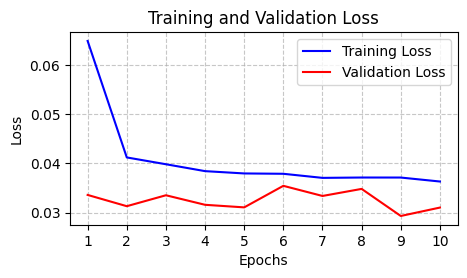

In [9]:
# Seguimiento del entrenamiento y overfitting
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2.5))
forecaster.plot_history(ax=ax)

In [10]:
%%time 
# Backtesting con datos de test
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:fin_val, :]), # Datos de entrenamiento + validación
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)
metrics

Epoch 1/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 0.0350 - val_loss: 0.0306
Epoch 2/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0343 - val_loss: 0.0315
Epoch 3/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0338 - val_loss: 0.0278
Epoch 4/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0347 - val_loss: 0.0279
Epoch 5/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0342 - val_loss: 0.0272
Epoch 6/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.0343 - val_loss: 0.0294
Epoch 7/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.0340 - val_loss: 0.0304
Epoch 8/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0341 - val_loss: 0.0409
Epoch 9/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0404 - val_loss: 0.0301
Epoch 10/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.0338 - val_loss: 0.0283


100%|██████████| 276/276 [00:27<00:00, 10.15it/s]

CPU times: total: 5min 16s
Wall time: 3min 16s


,levels,mean_absolute_error
0,CANTIDAD,3.174194


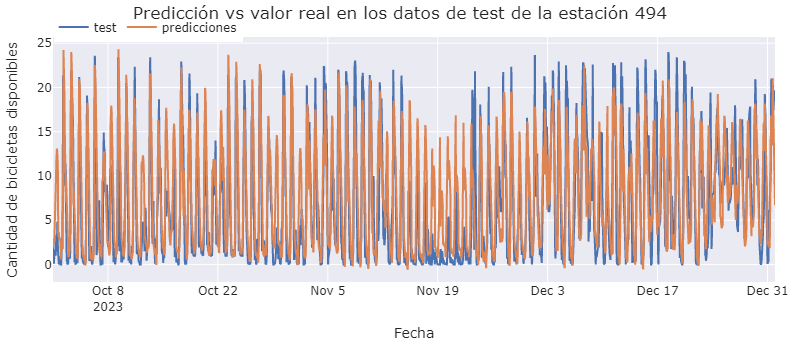

In [13]:
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['CANTIDAD'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['CANTIDAD'], name="predicciones", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test de la estación 494",
    xaxis_title="Fecha",
    yaxis_title="Cantidad de bicicletas disponibles",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
# fig.show() # Muestra la imagen en formato interactivo

static_image = pio.to_image(fig, format="png", engine="kaleido")
Image(static_image) # Muestra la imagen estática

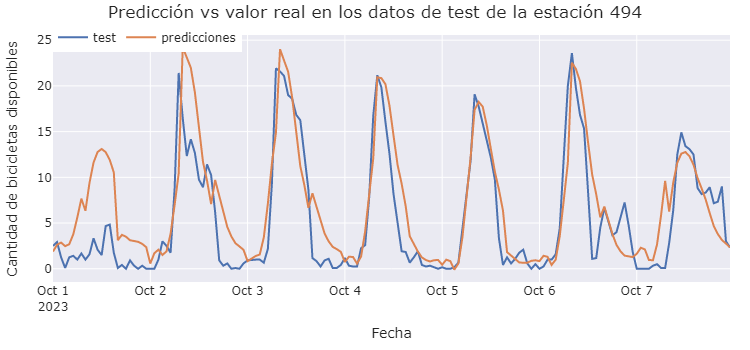

In [14]:
# Gráfico de las predicciones vs valores reales en el conjunto de test
# ==============================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test[0:168].index, y=data_test['CANTIDAD'][0:168], name="test", mode="lines")
trace2 = go.Scatter(x=predictions[0:168].index, y=predictions['CANTIDAD'][0:168], name="predicciones", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test de la estación 494",
    xaxis_title="Fecha",
    yaxis_title="Cantidad de bicicletas disponibles",
    width=750,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.05,
        xanchor="left",
        x=0
    )
)
# fig.show() # Muestra la imagen en formato interactivo

static_image = pio.to_image(fig, format="png", engine="kaleido")
Image(static_image) # Muestra la imagen estática